In [314]:
import pandas as pd
import numpy as np
import matplotlib as mpl

In [3]:
wine_df = pd.read_csv('data/wine.csv')
#dropping catagorical features, quality and type
wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,2
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [158]:
df = pd.concat([wine_df,pd.get_dummies(wine_df.quality,prefix='quality'),pd.get_dummies(wine_df.wine_type,prefix='wine_type')],axis=1)

In [159]:
df = df.drop(['quality','wine_type'],axis=1)

In [131]:
wine_df.wine_type.value_counts()

2    4898
1    1599
Name: wine_type, dtype: int64

In [132]:
wine_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [133]:
dfshape = df.shape

In [134]:
df.iloc[0,4]

0.045

Need to figure out some random locs to sub sample, we can do this based on a percentage of rows/colums or total points

In [135]:
def random_loc(data_frame_shape):
    col = np.random.randint(0,dfshape[1])
    row = np.random.randint(0,dfshape[0])
    return row,col

In [136]:
random_loc(dfshape)

(3570, 1)

In [137]:
random_loc(dfshape)[0]

2251

In [121]:
df.iloc[random_loc(dfshape)[0],random_loc(dfshape)[1]]

0.0

In [160]:
def induce_missingness(dataframe,percent):
    num2nan = int(dataframe.shape[0]*dataframe.shape[1]*percent)
    
    dfout = dataframe.copy()
    
    for _ in range(num2nan): 
        
        randloc = random_loc(dataframe.shape)
        
        while dfout.iloc[randloc[0],randloc[1]] == np.nan:
            randloc = random_loc(dataframe.shape)
            
        dfout.iloc[randloc[0],randloc[1]] = np.nan
        
        
    
    return dfout 
    

In [170]:
dout = induce_missingness(df,0.01)
dout.isna().sum()

fixed_acidity           51
volatile_acidity        70
citric_acid             75
residual_sugar          75
chlorides               61
free_sulfur_dioxide     58
total_sulfur_dioxide    58
density                 69
pH                      70
sulphates               74
alcohol                 55
quality_3               76
quality_4               55
quality_5               73
quality_6               71
quality_7               68
quality_8               57
quality_9               63
wine_type_1             50
wine_type_2             60
dtype: int64

In [183]:
dout.isna().any()

fixed_acidity           True
volatile_acidity        True
citric_acid             True
residual_sugar          True
chlorides               True
free_sulfur_dioxide     True
total_sulfur_dioxide    True
density                 True
pH                      True
sulphates               True
alcohol                 True
quality_3               True
quality_4               True
quality_5               True
quality_6               True
quality_7               True
quality_8               True
quality_9               True
wine_type_1             True
wine_type_2             True
dtype: bool

In [194]:
df.shape

(6497, 20)

In [185]:
from sklearn.preprocessing import MinMaxScaler

In [191]:
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
df_scaled = scaler.transform(df.to_numpy())

In [195]:
darray = df_scaled

In [290]:
from Models.simple_VAE import VAE
import argparse
import torch
import torch.utils.data 
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [197]:
def RMSE(darray,recon):
    return np.sqrt(np.mean(np.square(darray - recon)))

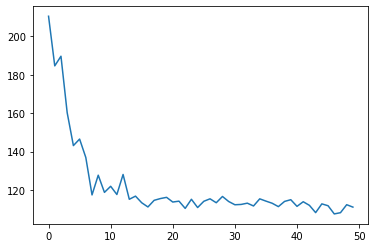

0.05294435

In [353]:
   #Sending scaled data to device

dtensor = torch.FloatTensor(darray[100:,:])
device = torch.device("cpu")
model = VAE(num_feats = 20,latent_dims=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)



def train_model(data_array=dtensor,model_in=model,
                optimizer_in=optimizer,device_in=device,epochs=50,batch_size=125):
    
    
    data_iter = DataLoader(dtensor,batch_size=batch_size, shuffle=True)
    model_in.train()

    loss_store = []

    for epoch in range(epochs): 
        for (idx, batch) in enumerate(data_iter):
        
        
            batch_in = batch.float()
        
        
            drecon,mu,log_var =  model(batch_in)
            optimizer_in.zero_grad()
            loss = model_in.loss(drecon, batch_in)
            loss.backward()
            optimizer_in.step()


        loss_store.append(loss.item())

    
    plt.plot(loss_store)
    plt.show()

    model_in.eval()
    drecon,mu,log_var =  model(dtensor)
    recon_array = drecon.detach().numpy()
    input_array = dtensor.detach().numpy()#dtensor.detach().numpy()

    return RMSE(input_array,recon_array)

train_model()

In [308]:
test_recon,mu_test,log_var = model(torch.FloatTensor(test))
z = model.reparam(mu_test,log_var).detach().numpy()

In [309]:

z_embedded = TSNE(n_components=2).fit_transform(z)
#>>> X_embedded.shape
#print(z_embedded)

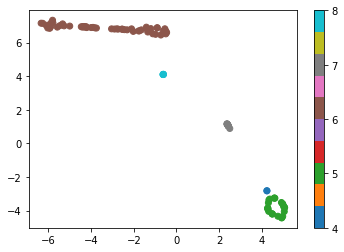

In [335]:
colours = wine_df['quality'].iloc[:100].to_numpy()
bounds = list(set(wine_df['quality'].iloc[:100].to_numpy()))
sc = plt.scatter(z_embedded[:,0],z_embedded[:,1],c=colours, cmap='tab10')
plt.colorbar(sc, ticks=bounds)
plt.show()

In [342]:
def plot_latent_space(data_in,model_in,labels):
    """"""
    test_recon3,mu_out,log_out = model_in(torch.FloatTensor(data_in))
    zout = model_in.reparam(mu_out,log_out).detach().numpy()
    
    z_emb  = TSNE(n_components=2).fit_transform(zout)
    
    colours = labels.to_numpy()
    bounds = list(set(labels.to_numpy()))
    sc = plt.scatter(z_emb[:,0],z_emb[:,1],c=colours, cmap='tab10')
    plt.colorbar(sc, ticks=bounds)
    plt.show()

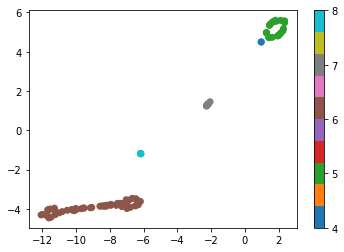

In [343]:
plot_latent_space(test,model,wine_df['quality'].iloc[:100])

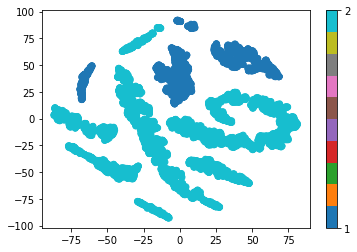

In [346]:
plot_latent_space(darray[100:,:],model,wine_df['wine_type'].iloc[100:]) 

In [365]:
df_shuffle = df.sample(frac=1)
df_test    = df_shuffle.iloc[-1200:,:].reset_index(drop=True)
df_train   = df_shuffle.iloc[:-1200,:].reset_index(drop=True)
#roughly 20% train test split

In [367]:
induce_missingness(df_test,0.3)

IndexError: single positional indexer is out-of-bounds

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
6299,7.9,0.69,0.21,2.1,0.080,33.0,141.0,0.99620,3.25,0.51,9.9,0,0,1,0,0,0,0,1,0
2126,6.5,0.43,0.28,12.0,0.056,23.0,174.0,0.99860,3.31,0.55,9.3,0,0,1,0,0,0,0,0,1
1880,7.7,0.30,0.42,14.3,0.045,45.0,213.0,0.99910,3.18,0.63,9.2,0,0,1,0,0,0,0,0,1
512,7.3,0.26,0.36,5.2,0.040,31.0,141.0,0.99310,3.16,0.59,11.0,0,0,0,1,0,0,0,0,1
1819,6.8,0.33,0.28,1.2,0.032,38.0,131.0,0.98890,3.19,0.41,13.0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6302,8.0,0.50,0.39,2.6,0.082,12.0,46.0,0.99850,3.43,0.62,10.7,0,0,0,1,0,0,0,1,0
2501,6.4,0.31,0.40,6.4,0.039,39.0,191.0,0.99513,3.14,0.52,9.8,0,0,1,0,0,0,0,0,1
3005,6.9,0.30,0.36,0.9,0.037,40.0,156.0,0.98968,3.08,0.36,12.1,0,0,0,1,0,0,0,0,1
932,6.5,0.26,0.28,12.5,0.046,80.0,225.0,0.99685,3.18,0.41,10.0,0,0,0,1,0,0,0,0,1
